# Goal 

In this blog post, we implement simple gradient descent, stochastic gradient descent, and a momentum method. These are all helpful algorithms to optimize convex functions given that finding any local minimizer is equivalent to finding the global minimizer for these kind of functions. Then, we compare the performance of these three algorithms for training logistic regression. 

# Link to Code 


<https://github.com/eduparlema/eduparlema.github.io/blob/main/posts/logistic-regression/logisticRegression.py>

# Walk-through of the standard gradient descent 


In [160]:
%reload_ext autoreload 
%autoreload 2

def fit(self, X ,y, alpha=0.01, max_epochs=100):
        """
        Fits weights to data using standard gradient descent. 
        """
        X_ = self.pad(X)
        self.w = .5 - np.random.rand(X.shape[1] + 1)
        
        self.loss_history = [self.loss(X_, y)]
        self.score_history = [self.score(X_, y)]

        #Gradient descent 
        for _ in range(max_epochs):

            grad = self.gradient(self.w, X_, y)
            self.w -= alpha * grad

            self.loss_history.append(self.loss(X_, y))
            self.score_history.append(self.score(X_, y))

            #Convergence in gradient descent
            if np.isclose(self.loss_history[-1], self.loss_history[-2]):
                break 

We first modify $X$ so that it has an extra column of 1's. This allow us to simplify the code as we can include the bias $b$ as part of $\textbf{w}$. Then, we start our algorithm with a random value for $\textbf{w}$, which we use to initialize the score_history and loss_history arrays. We then start the descent, updating the values of $\textbf{w}$ until we have reached the max_epochs or the descent converges. 

# Walk-through of the standard gradient descent 



In [ ]:
def fit_stochastic(self, X, y, alpha=0.01, max_epochs=1000, batch_size=10, momentum = False):
        """
        Fits weights to data using stochastic gradient descent.
        """
        n = X.shape[0]

        self.w = .5 - np.random.rand(X.shape[1] + 1)
        beta = 0.9 if momentum else 0
        self.loss_history = [self.loss(self.pad(X), y)]  

        prev_w = 0 

        for j in np.arange(max_epochs):
            
            order = np.arange(n)
            np.random.shuffle(order)

            for batch in np.array_split(order, n // batch_size + 1):
                x_batch = X[batch,:]
                y_batch = y[batch]

                grad = self.gradient(self.w, self.pad(x_batch), y_batch) 

                temp = self.w
                self.w = self.w - (grad * alpha) + beta*(self.w - prev_w)
                prev_w = temp
            
            self.loss_history.append(self.loss(self.pad(X), y))
        
            if np.isclose(self.loss_history[-1], self.loss_history[-2]):
                break 

This is very similar to the previous method, but instead of computing the complete gradient, we compute a stochastic gradient, by picking a random subset $S\in {1, 2, \dots, n}$, where $n$ is the number of the data points. This is achieved with an additional inner foor loop, which splits a shuffled version of ${1, 2, \dots, n}$ and then calculates the gradient as above. However, if the optional parameters "momentum" is set to True. Then we initialize an additional variable beta which has an effect on the gradient descent step. The momentum method takes into account the previous value $\textbf{w}$. To store the previous value of variable, we use a temporary variable for $\textbf{w}$ before we update it. Finally, similarly as before, we simply end the function if the descent converges or we have reached the max_epochs. 

# Experiments 

## Experiment 1

In [ ]:
from logisticRegression import LogisticRegression # your source code
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
import numpy as np

np.seterr(all='ignore') 

def draw_line(w, x_min, x_max):
  x = np.linspace(x_min, x_max, 101)
  y = -(w[0]*x + w[2])/w[1]
  plt.plot(x, y, color = "black")

In this experiment we will explore how the outcome of the gradient descent changes depending on the value of the learning rate alpha. 

0.92


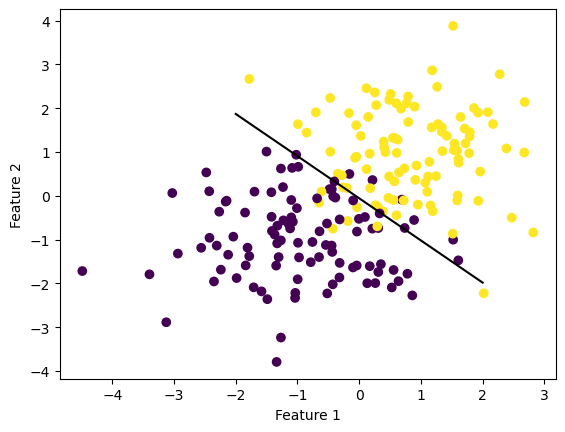

In [169]:
p_features = 3
X, y = make_blobs(n_samples = 200, n_features = p_features - 1, centers = [(-1, -1), (1, 1)])

LR = LogisticRegression()
LR.fit(X, y, alpha = 0.5, max_epochs=1000)

fig = plt.scatter(X[:,0], X[:,1], c = y)
fig = draw_line(LR.w, -2, 2)
xlab = plt.xlabel("Feature 1")
ylab = plt.ylabel("Feature 2")

print(LR.score_history[-1])

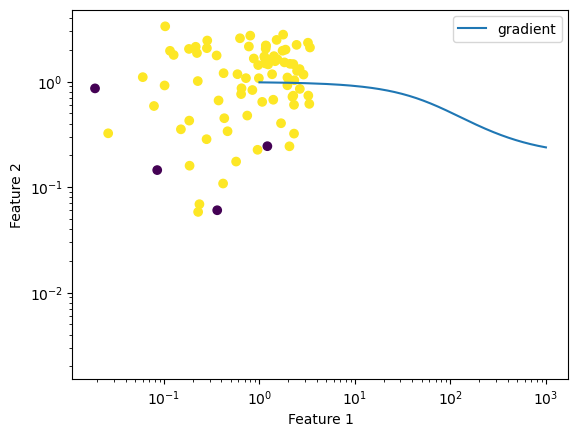

In [170]:
from logisticRegression import LogisticRegression # your source code
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
import numpy as np

np.seterr(all='ignore') 

def draw_line(w, x_min, x_max):
  x = np.linspace(x_min, x_max, 101)
  y = -(w[0]*x + w[2])/w[1]
  plt.plot(x, y, color = "black")

# make the data
p_features = 3
X, y = make_blobs(n_samples = 200, n_features = p_features - 1, centers = [(-1, -1), (1, 1)])

LR = LogisticRegression()
LR.fit(X, y, alpha = 0.01, max_epochs=1000)

fig = plt.scatter(X[:,0], X[:,1], c = y)
fig = draw_line(LR.w, -2, 2)
xlab = plt.xlabel("Feature 1")
ylab = plt.ylabel("Feature 2")


num_steps = len(LR.loss_history)

accuracy_fig = plt.plot(np.arange(num_steps) + 1, LR.loss_history, label = "gradient")

plt.loglog()

legend = plt.legend() 





In [ ]:

from logisticRegression import LogisticRegression # your source code
from sklearn.datasets import make_blobs
from matplotlib import pyplot as plt
import numpy as np

np.seterr(all='ignore') 

def draw_line(w, x_min, x_max):
  x = np.linspace(x_min, x_max, 101)
  y = -(w[0]*x + w[2])/w[1]
  plt.plot(x, y, color = "black")

# make the data
p_features = 3
X, y = make_blobs(n_samples = 200, n_features = p_features - 1, centers = [(-1, -1), (1, 1)])

LR = LogisticRegression()
LR.fit(X, y, alpha = 0.01, max_epochs=1000)

fig = plt.scatter(X[:,0], X[:,1], c = y)
fig = draw_line(LR.w, -2, 2)
xlab = plt.xlabel("Feature 1")
ylab = plt.ylabel("Feature 2")



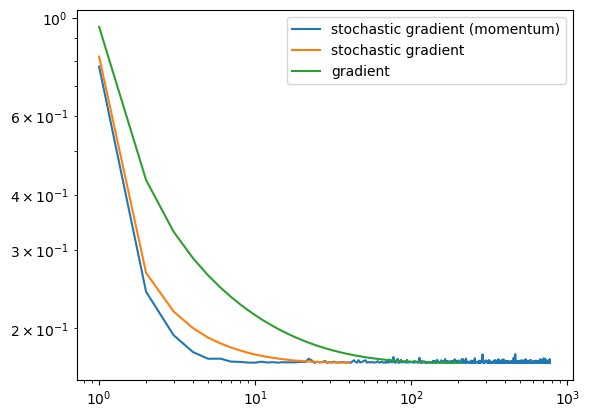

In [159]:
LR = LogisticRegression()
LR.fit_stochastic(X, y, 
                  max_epochs = 1000, 
                  momentum = True, 
                  batch_size = 5, 
                  alpha = 0.1) 

num_steps = len(LR.loss_history)
plt.plot(np.arange(num_steps) + 1, LR.loss_history, label = "stochastic gradient (momentum)")

LR = LogisticRegression()
LR.fit_stochastic(X, y, 
                  max_epochs = 1000, 
                  momentum = False, 
                  batch_size = 5, 
                  alpha = 0.1)

num_steps = len(LR.loss_history)
plt.plot(np.arange(num_steps) + 1, LR.loss_history, label = "stochastic gradient")

LR = LogisticRegression()
LR.fit(X, y, alpha = 0.9, max_epochs = 1000)

num_steps = len(LR.loss_history)
plt.plot(np.arange(num_steps) + 1, LR.loss_history, label = "gradient")

plt.loglog()

legend = plt.legend() 